# Content table

1. Client
2. Server

## Installing dependencies

In [3]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import datetime
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

import flwr as fl
from torchsummary import summary
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple

# import color
import os
import multiprocessing as mp
import warnings
warnings.filterwarnings('ignore')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cores = mp.cpu_count()
# c = color.clr()
# print(c.SUCCESS('Day:'), datetime.datetime.now())
# print(c.SUCCESS('Device:'), device)
# print(c.SUCCESS('Core:'), cores)

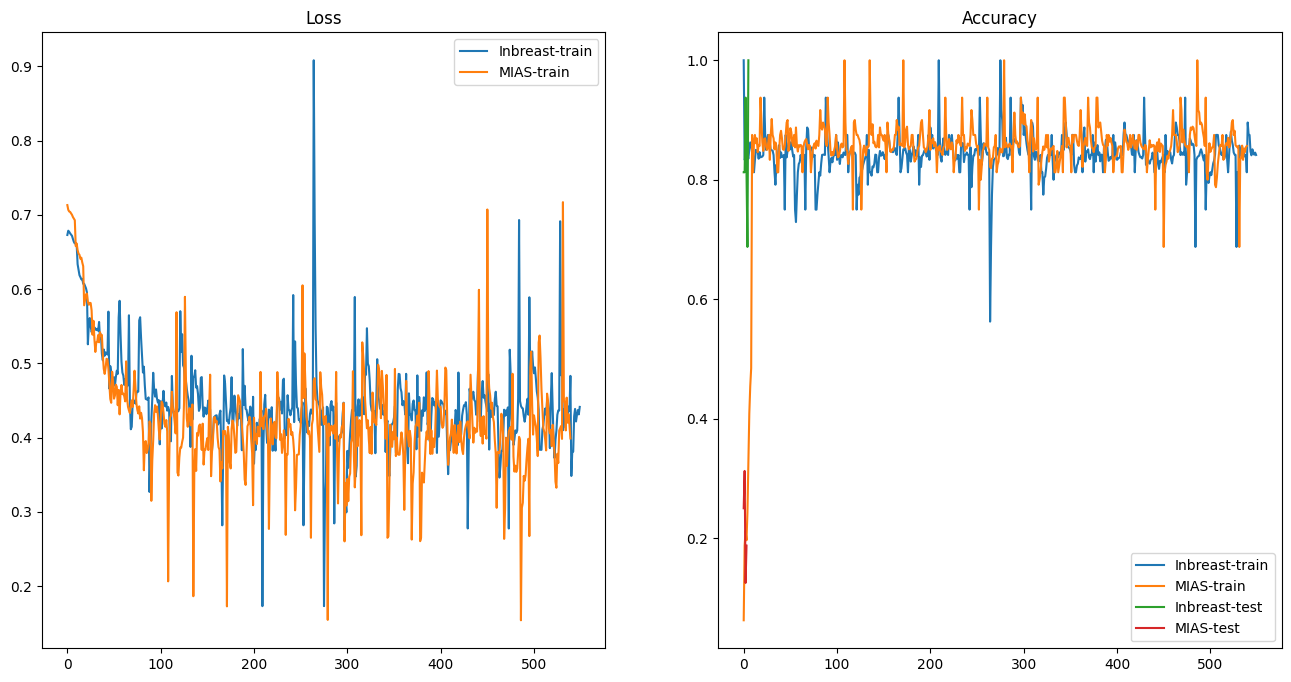

In [17]:
df_in_test = pd.read_csv('Federated_learning\output\inbreast_test.csv')
df_in_train = pd.read_csv('Federated_learning\output\inbreast_train.csv')
df_mi_test = pd.read_csv('Federated_learning\output\mias_test.csv')
df_mi_train = pd.read_csv('Federated_learning\output\mias_train.csv')

plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(df_in_train['loss'], label='Inbreast-train')
plt.plot(df_mi_train['loss'], label='MIAS-train')
# plt.plot(df_in_test['loss'], label='Inbreast-test')
# plt.plot(df_mi_test['loss'], label='MIAS-test')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(df_in_train['accuracy'], label='Inbreast-train')
plt.plot(df_mi_train['accuracy'], label='MIAS-train')
plt.plot(df_in_test['accuracy'], label='Inbreast-test')
plt.plot(df_mi_test['accuracy'], label='MIAS-test')
plt.legend()

plt.savefig(f'loss_acc.png')
plt.show()

# 1. Setup client

In [8]:

BATCH_SIZE = 16
SIZE_IMAGE = (227, 227)
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5)),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomVerticalFlip(),
                                transforms.Resize(SIZE_IMAGE)])

def pre_process(img):
    '''
    pre-process image before training
    algorithm: CLAHE (Contrast Limited Adaptive Histogram Equalization)
    '''
    img = img.astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8, 8))
    img_clahe = clahe.apply(img)
    return img_clahe

# --- Data ---
class Dataset():
    def __init__(self, path_data, transform=None):
        self.path_data = path_data.upper()
        self.df = pd.read_csv(f'dataset/{self.path_data}-ROI-Mammography/description.csv')
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        image_path = f'dataset/{self.path_data}-ROI-Mammography/{self.df.iloc[index].Path_save}'
        image = cv2.imread(image_path, 0)
        if self.transform:
            image = pre_process(image)
            image = self.transform(image)
        label = self.df.iloc[index]['Cancer']
        return image, label
    
def train_test_split(dataset, test_size=0.2):
    s_test = int(test_size * dataset.__len__())
    s_train = dataset.__len__() - s_test
    train_dataset, test_dataset = random_split(dataset, [s_train, s_test])
    return train_dataset, test_dataset
    
def dataloader(train_dataset, test_dataset, batch_size=16):
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_dataloader, test_dataloader

def show_transform(dataloader):
    images, labels = next(iter(dataloader))
    # Reshape and convert images to a NumPy array
    # matplotlib requires images with the shape (height, width, 3)
    images = images.permute(0, 2, 3, 1).numpy()
    # Denormalize
    images = images / 2 + 0.5
    # Create a figure and a grid of subplots
    fig, axs = plt.subplots(4, 4, figsize=(10, 10))
    # Loop over the images and plot them
    for i, ax in enumerate(axs.flat):
        ax.imshow(images[i], cmap='gray')
        ax.set_title(labels[i].item())
        ax.axis("off")
    # Show the plot
    fig.tight_layout()
    plt.show()

def show_origin(dataset):
    fig, axs = plt.subplots(4, 4, figsize=(10, 10))
    for i, ax in enumerate(axs.flat):
        img = cv2.imread(f'dataset/{dataset.path_data}-ROI-Mammography/{dataset.df.iloc[i].Path_save}', 0)
        ax.imshow(img, cmap='gray')
        ax.set_title(dataset.df.iloc[i].Cancer)
        ax.axis("off")
    fig.tight_layout()
    plt.show()
    
# --- Model ---
# google net
class InceptionModule(nn.Module):
    def __init__(self, in_channels, out1x1, reduce3x3, out3x3, reduce5x5, out5x5, out1x1pool):
        super(InceptionModule, self).__init__()

        # 1x1 convolution branch
        self.branch1x1 = nn.Conv2d(in_channels, out1x1, kernel_size=1)

        # 1x1 convolution followed by 3x3 convolution branch
        self.branch3x3 = nn.Sequential(
            nn.Conv2d(in_channels, reduce3x3, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(reduce3x3, out3x3, kernel_size=3, padding=1)
        )

        # 1x1 convolution followed by 5x5 convolution branch
        self.branch5x5 = nn.Sequential(
            nn.Conv2d(in_channels, reduce5x5, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(reduce5x5, out5x5, kernel_size=5, padding=2)
        )

        # 3x3 max pooling followed by 1x1 convolution branch
        self.branch1x1pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, out1x1pool, kernel_size=1)
        )

    def forward(self, x):
        branch1x1 = self.branch1x1(x)
        branch3x3 = self.branch3x3(x)
        branch5x5 = self.branch5x5(x)
        branch1x1pool = self.branch1x1pool(x)
        outputs = [branch1x1, branch3x3, branch5x5, branch1x1pool]
        return torch.cat(outputs, 1)

class GoogLeNet(nn.Module):
    def __init__(self, num_classes=2):
        super(GoogLeNet, self).__init__()

        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=1)
        self.conv3 = nn.Conv2d(64, 192, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception3a = InceptionModule(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionModule(256, 128, 128, 192, 32, 96, 64)

        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception4a = InceptionModule(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = InceptionModule(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = InceptionModule(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = InceptionModule(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = InceptionModule(528, 256, 160, 320, 32, 128, 128)

        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception5a = InceptionModule(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = InceptionModule(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.maxpool2(x)
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)
        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.inception4e(x)
        x = self.maxpool4(x)
        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

# lenet
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 1280)
        self.fc2 = nn.Linear(1280, 128)
        self.fc3 = nn.Linear(128, 2)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

# --- Training ---
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    loop = tqdm(train_loader, desc='Training')
    for inputs, labels in loop:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += torch.sum(predicted == labels.data).item()
        acc_cur = torch.sum(predicted == labels.data).item()/labels.size(0)
        loop.set_postfix(loss=loss.item(), acc=acc_cur)
    
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    
    return train_loss, train_acc

def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        loop = tqdm(val_loader, desc='Validation')
        for inputs, labels in loop:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += torch.sum(predicted == labels.data).item()
            acc_cur = torch.sum(predicted == labels.data).item()/labels.size(0)
            loop.set_postfix(loss=loss.item(), acc=acc_cur)
    
    val_loss = running_loss / len(val_loader)
    val_acc = correct / total
    
    return val_loss, val_acc

def fit(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=20):
    lst_acc = {'train': [], 'val': []}
    lst_loss = {'train': [], 'val': []}
    best_val_acc = 0.0
    for epoch in range(num_epochs):
        print(c.SUCCESS('Epoch {}/{}'.format(epoch+1, num_epochs)))
        print('-'*50)

        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        print('Train Loss: {:.4f} - Train Acc: {:.4f}'.format(train_loss, train_acc))
        print('Val Loss: {:.4f} - Val Acc: {:.4f}'.format(val_loss, val_acc))
        print('+'*100)

        lst_acc['train'].append(train_acc)
        lst_acc['val'].append(val_acc)
        lst_loss['train'].append(train_loss)
        lst_loss['val'].append(val_loss)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'result/best_model.pth')
    print(c.SUCCESS('Training and validation completed!'))
    return lst_acc, lst_loss

# --- client ---
class client():
    def __init__(self, name_client, batch_size, model, criterion, optimizer):
        self.name_client = name_client.upper()
        self.df = Dataset(self.name_client, transform)
        self.df_train, self.df_val = train_test_split(self.df)
        self.train_loader, self.val_loader = dataloader(self.df_train, self.df_val, batch_size)
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer

    def run(self, epochs=5):
        lst_acc, lst_loss = fit(self.model, self.train_loader, self.val_loader, self.criterion, self.optimizer, device, num_epochs=epochs)
        plt.figure(figsize=(15, 5))
        plt.suptitle(f'Client {self.name_client}')
        plt.subplot(1, 2, 1)
        plt.plot(lst_acc['train'], label='train')
        plt.plot(lst_acc['val'], label='val')
        plt.title('Accuracy')
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.plot(lst_loss['train'], label='train')
        plt.plot(lst_loss['val'], label='val')
        plt.title('Loss')
        plt.legend()
        plt.savefig(f'result/{self.name_client}.png')
        plt.show()
    
    def get_summary(self):
        return summary(self.model, (1, 227, 227))
    
    def get_parameters(self):
        return get_parameters(self.model)

model = GoogLeNet(num_classes=2).to(device)
summary(model, (1, 227, 227))
# model = Net().to(device)
# criteria = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.01)
# client1 = client('MIAS', 16, model, criteria, optimizer)
# client1.run(2)

Epoch 1/2
--------------------------------------------------


Training:   0%|          | 0/17 [00:03<?, ?it/s]


KeyboardInterrupt: 

In [10]:
show_transform(dataloader)

TypeError: 'function' object is not iterable